### 1. Import Package

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

### 2. Read Dataset

In [33]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
target = 'Survived'
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 3. Train-Val Split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(
    train, train[target], stratify=train[target], test_size=0.2, random_state=0)

### 4. Function Definition

In [36]:
def adjust_nan_value(df):
    
    df_num = df.select_dtypes(exclude=['object'])
    dict_num = dict(df_num.describe().loc['50%'])
    
    return dict_num

def adjust_nan_value_categorical(df):
    
    df = df.select_dtypes(include='object')
    dict_cat = dict(df.describe().loc['top'])

    return dict_cat

### 5. Feature Engineering

In [37]:
def generate_name_length(df):
    df['Name_Length'] = df.Name.str.split(' ').str.len()
    return df

def generate_title(df):
    df['Title'] = df.Name.str.split(', ').str[1].str[1].str[:-1]
    return df

def generate_cabin_info(df):
    df['cabin info'] = train.Cabin.isnull().map({True: 'no_cabin_data', False: 'have_cabin_data'})
    return df

def generate_age(df):
    average_age_titanic = df['Age'].mean()
    std_age_titanic = df['Age'].std()
    nan_size = df['Age'].isnull().sum()
    rand = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = nan_size)
    df["Age"][np.isnan(df["Age"])] = rand
    return df

def generate_family_size(df):
    df['Family_size'] = df['SibSp'] + df['Parch'] + 1
    return df

def generate_gender_class(df):
    df['Gender_class'] = df.apply(lambda x: 1 if ((x['Sex'] == 'female') & (x['Pclass'] == 1)) |
                                                 ((x['Sex'] == 'female') & (x['Pclass'] == 2)) else 0, axis=1)
    return df

def generate_fare_binding(df):
    df['Fare_binding'] = df[['Fare', 'Pclass']].apply(
        lambda x: 'high' if x['Fare'] >= 100 else 'medium' if x['Pclass'] == 1 else 'low', axis=1)
    return df

### 6. Modeling on Cross Validation

In [38]:
kf = StratifiedKFold(n_splits=5, random_state=0)

In [39]:
accs_decision_tree = []
accs_logistic_regression = []
accs_random_forest = []
accs_naive_bayes = []
accs_svc = []
accs_adaboost = []
for train_index, test_index in kf.split(X_train, y_train):
    
    ### Define train and test on cross validation
    df_train, df_test = X_train.iloc[train_index], X_train.iloc[test_index]
    df_target_train = df_train['Survived']
    df_target_test = df_test['Survived']
    
    ### feature engineering
    df_train = generate_fare_binding(df_train)
    df_train = generate_family_size(df_train)
    df_train = generate_gender_class(df_train)

    df_test = generate_fare_binding(df_test)
    df_test = generate_family_size(df_test)
    df_test = generate_gender_class(df_test)
    
    ### Drop useless features
    drop_vars = ['PassengerId', 
                 'Survived', 
                 'Cabin', 
                 'Name', 
                 'Ticket', 
                 'Pclass',  
                 'Age',
                 'Fare', 
                 'SibSp', 
                 'Parch']
    
    df_train = df_train.drop(drop_vars, axis=1)
    df_test = df_test.drop(drop_vars, axis=1)

    ### Nan value adjustment for default
    dict_cat = adjust_nan_value_categorical(df_train)
    
    for cat, val in zip(dict_cat.keys(), dict_cat.values()):
        df_train[cat] = df_train[cat].fillna(val)

    for cat, val in zip(dict_cat.keys(), dict_cat.values()):
        df_test[cat] = df_test[cat].fillna(val)
    
    ### One-Hot Encoding
    ohe_train = pd.get_dummies(df_train)
    ohe_test = pd.get_dummies(df_test)
    
    ### Decision Tree Classifier
    clf = DecisionTreeClassifier()
    clf.fit(ohe_train, df_target_train)
    y_prob_DT_train = clf.predict_proba(ohe_train)[:,1]
    y_prob_DT_test = clf.predict_proba(ohe_test)[:,1]
    
    ### Logistic Regression Classifier
    clf = LogisticRegression()
    clf.fit(ohe_train, df_target_train)
    y_prob_LR_train = clf.predict_proba(ohe_train)[:,1]
    y_prob_LR_test = clf.predict_proba(ohe_test)[:,1]
    
    ### Random Forest Classifier
    clf = RandomForestClassifier()
    clf.fit(ohe_train, df_target_train)
    y_prob_RF_train = clf.predict_proba(ohe_train)[:,1]
    y_prob_RF_test = clf.predict_proba(ohe_test)[:,1]
    
    ### Naive Bayes Classifier
    clf = GaussianNB()
    clf.fit(ohe_train, df_target_train)
    y_prob_NB_train = clf.predict_proba(ohe_train)[:,1]
    y_prob_NB_test = clf.predict_proba(ohe_test)[:,1]
    
    ### Adaboost Classifier
    clf = AdaBoostClassifier()
    clf.fit(ohe_train, df_target_train)
    y_prob_AB_train = clf.predict_proba(ohe_train)[:,1]
    y_prob_AB_test = clf.predict_proba(ohe_test)[:,1]
    
    ohe_train['features_DT'] = y_prob_DT_train
    ohe_test['features_DT'] = y_prob_DT_test
    
    ohe_train['features_LR'] = y_prob_LR_train
    ohe_test['features_LR'] = y_prob_LR_test
    
    ohe_train['features_RF'] = y_prob_RF_train
    ohe_test['features_RF'] = y_prob_RF_test
    
    ohe_train['features_NB'] = y_prob_NB_train
    ohe_test['features_NB'] = y_prob_NB_test
    
    ohe_train['features_AB'] = y_prob_AB_train
    ohe_test['features_AB'] = y_prob_AB_test
    
    derivative_features = ['features_DT',
                           'features_LR',
                           'features_RF',
                           'features_NB',
                           'features_AB']
    
    ohe_train = ohe_train[derivative_features]
    ohe_test = ohe_test[derivative_features]
    
    ### Decision Tree Classifier
    clf = DecisionTreeClassifier()
    clf.fit(ohe_train, df_target_train)
    
    y_pred = clf.predict(ohe_test)
    accs_decision_tree.append(accuracy_score(df_target_test, y_pred))
    
    ### Logistic Regression Classifier
    clf = LogisticRegression()
    clf.fit(ohe_train, df_target_train)
    
    y_pred = clf.predict(ohe_test)
    accs_logistic_regression.append(accuracy_score(df_target_test, y_pred))
    
    ### Random Forest Classifier
    clf = RandomForestClassifier()
    clf.fit(ohe_train, df_target_train)
    
    y_pred = clf.predict(ohe_test)
    accs_random_forest.append(accuracy_score(df_target_test, y_pred))
    
    ### Naive Bayes Classifier
    clf = GaussianNB()
    clf.fit(ohe_train, df_target_train)
    
    y_pred = clf.predict(ohe_test)
    accs_naive_bayes.append(accuracy_score(df_target_test, y_pred))
    
    ### SVM Classifier
    clf = SVC()
    clf.fit(ohe_train, df_target_train)
    
    y_pred = clf.predict(ohe_test)
    accs_svc.append(accuracy_score(df_target_test, y_pred))
    
    ### Adaboost Classifier
    clf = AdaBoostClassifier()
    clf.fit(ohe_train, df_target_train)
    
    y_pred = clf.predict(ohe_test)
    accs_adaboost.append(accuracy_score(df_target_test, y_pred))
    
accs = pd.DataFrame()
accs['accuracy_LR'] = accs_logistic_regression
accs['accuracy_DT'] = accs_decision_tree
accs['accuracy_RF'] = accs_random_forest
accs['accuracy_NB'] = accs_naive_bayes
accs['accuracy_SV'] = accs_svc
accs['accuracy_AB'] = accs_adaboost

C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [17]:
accs

,accuracy_LR,accuracy_DT,accuracy_RF,accuracy_NB,accuracy_SV,accuracy_AB
0,0.825175,0.818182,0.818182,0.811189,0.839161,0.818182
1,0.797203,0.797203,0.783217,0.811189,0.797203,0.797203
2,0.825175,0.839161,0.818182,0.790210,0.825175,0.832168
3,0.767606,0.774648,0.774648,0.760563,0.781690,0.774648
4,0.815603,0.794326,0.808511,0.822695,0.815603,0.787234


In [18]:
accs.mean()

accuracy_LR    0.806152
accuracy_DT    0.804704
accuracy_RF    0.800548
accuracy_NB    0.799169
accuracy_SV    0.811766
accuracy_AB    0.801887
dtype: float64

### 7. Hyperparameter Tuning

In [19]:
### Define train and test on validation set
df_train = X_train.copy() 
df_test = X_val.copy()
df_target_train = df_train['Survived']
df_target_test = df_test['Survived']

### feature engineering
df_train = generate_fare_binding(df_train)
df_train = generate_family_size(df_train)
df_train = generate_gender_class(df_train)

df_test = generate_fare_binding(df_test)
df_test = generate_family_size(df_test)
df_test = generate_gender_class(df_test)

### Drop useless features
drop_vars = ['PassengerId', 
             'Survived', 
             'Cabin', 
             'Name', 
             'Ticket', 
             'Pclass',  
             'Age',
             'Fare', 
             'SibSp', 
             'Parch']

df_train = df_train.drop(drop_vars, axis=1)
df_test = df_test.drop(drop_vars, axis=1)

### Nan value adjustment for default
dict_cat = adjust_nan_value_categorical(df_train)

for cat, val in zip(dict_cat.keys(), dict_cat.values()):
    df_train[cat] = df_train[cat].fillna(val)

for cat, val in zip(dict_cat.keys(), dict_cat.values()):
    df_test[cat] = df_test[cat].fillna(val)

### One-Hot Encoding
ohe_train = pd.get_dummies(df_train)
ohe_test = pd.get_dummies(df_test)

### Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(ohe_train, df_target_train)
y_prob_DT_train = clf.predict_proba(ohe_train)[:,1]
y_prob_DT_test = clf.predict_proba(ohe_test)[:,1]

### Logistic Regression Classifier
clf = LogisticRegression()
clf.fit(ohe_train, df_target_train)
y_prob_LR_train = clf.predict_proba(ohe_train)[:,1]
y_prob_LR_test = clf.predict_proba(ohe_test)[:,1]

### Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(ohe_train, df_target_train)
y_prob_RF_train = clf.predict_proba(ohe_train)[:,1]
y_prob_RF_test = clf.predict_proba(ohe_test)[:,1]

### Naive Bayes Classifier
clf = GaussianNB()
clf.fit(ohe_train, df_target_train)
y_prob_NB_train = clf.predict_proba(ohe_train)[:,1]
y_prob_NB_test = clf.predict_proba(ohe_test)[:,1]

### Adaboost Classifier
clf = AdaBoostClassifier()
clf.fit(ohe_train, df_target_train)
y_prob_AB_train = clf.predict_proba(ohe_train)[:,1]
y_prob_AB_test = clf.predict_proba(ohe_test)[:,1]

ohe_train['features_DT'] = y_prob_DT_train
ohe_test['features_DT'] = y_prob_DT_test

ohe_train['features_LR'] = y_prob_LR_train
ohe_test['features_LR'] = y_prob_LR_test

ohe_train['features_RF'] = y_prob_RF_train
ohe_test['features_RF'] = y_prob_RF_test

ohe_train['features_NB'] = y_prob_NB_train
ohe_test['features_NB'] = y_prob_NB_test

ohe_train['features_AB'] = y_prob_AB_train
ohe_test['features_AB'] = y_prob_AB_test

derivative_features = ['features_DT',
                       'features_LR',
                       'features_RF',
                       'features_NB',
                       'features_AB']

ohe_train = ohe_train[derivative_features]
ohe_test = ohe_test[derivative_features]

C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
accs_svc = []
for gamma in [0.1, 0.01, 100]:
    for max_iter in [1000, 100, 10000]:
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            clf = SVC(gamma=gamma, 
                      max_iter=max_iter,
                      kernel=kernel)
            clf.fit(ohe_train, df_target_train)

            y_pred = clf.predict(ohe_test)
            acc_score = accuracy_score(df_target_test, y_pred)
            acc_note = 'gamma_{} | max_iter_{} | kernel_{}'.format(gamma, max_iter,kernel)
            accs_svc.append((acc_score, acc_note))

C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yeheskia-PC

In [41]:
accs_svc

[(0.7801418439716312, 'gamma_0.1 | max_iter_1000 | kernel_linear'),
 (0.8156028368794326, 'gamma_0.1 | max_iter_1000 | kernel_poly'),
 (0.8226950354609929, 'gamma_0.1 | max_iter_1000 | kernel_rbf'),
 (0.8226950354609929, 'gamma_0.1 | max_iter_1000 | kernel_sigmoid'),
 (0.7943262411347518, 'gamma_0.1 | max_iter_100 | kernel_linear'),
 (0.8226950354609929, 'gamma_0.1 | max_iter_100 | kernel_poly'),
 (0.8226950354609929, 'gamma_0.1 | max_iter_100 | kernel_rbf'),
 (0.8226950354609929, 'gamma_0.1 | max_iter_100 | kernel_sigmoid'),
 (0.7801418439716312, 'gamma_0.1 | max_iter_10000 | kernel_linear'),
 (0.8156028368794326, 'gamma_0.1 | max_iter_10000 | kernel_poly'),
 (0.8226950354609929, 'gamma_0.1 | max_iter_10000 | kernel_rbf'),
 (0.8226950354609929, 'gamma_0.1 | max_iter_10000 | kernel_sigmoid'),
 (0.7801418439716312, 'gamma_0.01 | max_iter_1000 | kernel_linear'),
 (0.6170212765957447, 'gamma_0.01 | max_iter_1000 | kernel_poly'),
 (0.8226950354609929, 'gamma_0.01 | max_iter_1000 | kernel_r

### 8. Modeling and test to validation data

In [42]:
accs_svc = []

clf = SVC(gamma=0.1, 
          max_iter=1000,
          kernel='poly',
          probability=True)
clf.fit(ohe_train, df_target_train)

y_prob_train = clf.predict_proba(ohe_train)
y_pred_train = clf.predict(ohe_train)
acc_score_train = accuracy_score(df_target_train, y_pred_train)

y_prob_test = clf.predict_proba(ohe_test)
y_pred_test = clf.predict(ohe_test)
acc_score_test = accuracy_score(df_target_test, y_pred_test)

In [43]:
acc_score_test

0.8156028368794326

### 9. Observing distribution

C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


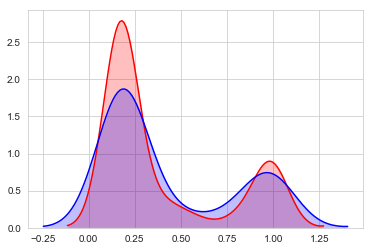

In [44]:
g = sns.kdeplot(y_prob_train[:, 1], color="Red", shade = True)
g = sns.kdeplot(y_prob_test[:, 1], ax =g, color="Blue", shade = True)

### 10. Final Modeling

In [45]:
### Define train and test on validation set
df_train = train.copy() 
df_test = test.copy()
df_target_train = df_train['Survived']

### feature engineering
df_train = generate_fare_binding(df_train)
df_train = generate_family_size(df_train)
df_train = generate_gender_class(df_train)

df_test = generate_fare_binding(df_test)
df_test = generate_family_size(df_test)
df_test = generate_gender_class(df_test)

### Drop useless features
drop_vars_train = ['PassengerId', 
             'Survived', 
             'Cabin', 
             'Name', 
             'Ticket', 
             'Pclass',  
             'Age',
             'Fare', 
             'SibSp', 
             'Parch']

drop_vars_test = ['PassengerId', 
             'Cabin', 
             'Name', 
             'Ticket', 
             'Pclass',  
             'Age',
             'Fare', 
             'SibSp', 
             'Parch']

df_train = df_train.drop(drop_vars_train, axis=1)
df_test = df_test.drop(drop_vars_test, axis=1)

### Nan value adjustment for default
dict_cat = adjust_nan_value_categorical(df_train)

for cat, val in zip(dict_cat.keys(), dict_cat.values()):
    df_train[cat] = df_train[cat].fillna(val)

for cat, val in zip(dict_cat.keys(), dict_cat.values()):
    df_test[cat] = df_test[cat].fillna(val)

### One-Hot Encoding
ohe_train = pd.get_dummies(df_train)
ohe_test = pd.get_dummies(df_test)

### Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(ohe_train, df_target_train)
y_prob_DT_train = clf.predict_proba(ohe_train)[:,1]
y_prob_DT_test = clf.predict_proba(ohe_test)[:,1]

### Logistic Regression Classifier
clf = LogisticRegression()
clf.fit(ohe_train, df_target_train)
y_prob_LR_train = clf.predict_proba(ohe_train)[:,1]
y_prob_LR_test = clf.predict_proba(ohe_test)[:,1]

### Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(ohe_train, df_target_train)
y_prob_RF_train = clf.predict_proba(ohe_train)[:,1]
y_prob_RF_test = clf.predict_proba(ohe_test)[:,1]

### Naive Bayes Classifier
clf = GaussianNB()
clf.fit(ohe_train, df_target_train)
y_prob_NB_train = clf.predict_proba(ohe_train)[:,1]
y_prob_NB_test = clf.predict_proba(ohe_test)[:,1]

### Adaboost Classifier
clf = AdaBoostClassifier()
clf.fit(ohe_train, df_target_train)
y_prob_AB_train = clf.predict_proba(ohe_train)[:,1]
y_prob_AB_test = clf.predict_proba(ohe_test)[:,1]

ohe_train['features_DT'] = y_prob_DT_train
ohe_test['features_DT'] = y_prob_DT_test

ohe_train['features_LR'] = y_prob_LR_train
ohe_test['features_LR'] = y_prob_LR_test

ohe_train['features_RF'] = y_prob_RF_train
ohe_test['features_RF'] = y_prob_RF_test

ohe_train['features_NB'] = y_prob_NB_train
ohe_test['features_NB'] = y_prob_NB_test

ohe_train['features_AB'] = y_prob_AB_train
ohe_test['features_AB'] = y_prob_AB_test

derivative_features = ['features_DT',
                       'features_LR',
                       'features_RF',
                       'features_NB',
                       'features_AB']

ohe_train = ohe_train[derivative_features]
ohe_test = ohe_test[derivative_features]

C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yeheskia-PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [46]:
clf = SVC(gamma=0.1, 
          max_iter=1000,
          kernel='poly',
          probability=True)
clf.fit(ohe_train, df_target_train)

y_pred_test = clf.predict(ohe_test)

### 11. Submission Preparation

In [47]:
df_submission = test.copy()
df_submission['Survived'] = y_pred_test

In [48]:
df_final = df_submission[['PassengerId', 'Survived']]

In [49]:
df_final.to_csv('titanic_submission_with_derivative_features_1.csv', index=False)